# 🏎️ F1 2024 Season Analysis
## By Giftson Justin

<img src="figures/F1-Logo.png" alt="F1 Logo" width="500"/>

This notebook analyses and visualises data from the **2024 Formula 1 season**, using Python.  
The goal is to highlight **driver performance, team dynamics, and season trends** through data-driven insights.  

We answer questions like:  
- Who scored the most points, wins, and podiums?  
- Which teams dominated the Constructors’ Championship?  
- Do qualifying positions really predict race finishes?  
- Which drivers consistently gain or lose positions during races?  

Along the way, we demonstrate practical **data cleaning, aggregation, and visualisation** techniques.  
The result is a **beginner-friendly project** that mixes sports storytelling with reproducible data science.

## 📦 Data Loading & Preparation  

In this step we:  
- **Import libraries** (`pandas`, `numpy`, `matplotlib`, `plotly`) for analysis & plots.  
- **Define file paths** (`DATA_FILES`) for drivers, teams, race results, etc.  
- **Standardise names** with:  
  - `TRACK_NAME_MAP` → consistent track names.  
  - `TEAM_REGEX_FIXES` → unify team names.  
  - `TEAM_COLORS` → colours for each team in plots.  
- **Helper functions**:  
  - `to_seconds_fastlap` → converts lap times to seconds.  
  - `load_all` → loads all CSVs at once.  
  - `clean_race_results` → cleans race results (numeric columns, DNFs, fastest laps).  
- **Load & clean data**:  
  - `dfs = load_all()` → loads all datasets.  
  - `race_results_clean` → cleaned dataset ready for analysis.  
  - `assert` check → confirms points are numeric.  

First, ensure your plotly and kaleido is in the correct version to work

In [1]:
# %pip install -U "plotly>=6.1.1" "kaleido>=1.1.0"

In [2]:
# Imports
import pandas as pd
import numpy as np
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import plotly.express as px
import re
import ipywidgets as widgets
import plotly.io as pio
import sys, plotly
import importlib.metadata as md

In [3]:
print("Python:", sys.executable)
print("Plotly:", plotly.__version__)
print("Kaleido:", md.version("kaleido"))

Python: /Users/gify1606/opt/anaconda3/bin/python
Plotly: 6.3.0
Kaleido: 1.1.0


In [69]:
from pathlib import Path

FIG_DIR = "docs"          # save interactive plots into /docs (served by GitHub Pages)
Path(FIG_DIR).mkdir(exist_ok=True)

In [4]:
# Helper used inside clean_race_results
def to_seconds_fastlap(s):
    if pd.isna(s): return np.nan
    s = str(s).strip()
    if not s or s in {"-", "NaN", "None"}: return np.nan
    try:
        return pd.to_timedelta("00:" + s).total_seconds()
    except Exception:
        try:
            return pd.to_timedelta(s).total_seconds()
        except Exception:
            return np.nan

In [5]:
# Data loading + cleaning helpers
def load_all():
    return {k: pd.read_csv(path) for k, path in DATA_FILES.items()}

def _normalize_teams(series: pd.Series) -> pd.Series:
    out = series.astype(str).str.strip().str.replace(r'\s+', ' ', regex=True)
    for pat, tgt in TEAM_REGEX_FIXES.items():
        out = out.str.replace(pat, tgt, regex=True, case=False)
    return out

def clean_race_results(df, driver_fixes=None, track_map=None):
    out = df.copy()
    out.columns = [c.strip() for c in out.columns]

    if "Driver" in out.columns:
        out["Driver"] = out["Driver"].astype(str).str.strip().str.title().replace(driver_fixes or {})

    if "Team" in out.columns:
        out["Team"] = _normalize_teams(out["Team"])

    if "Track" in out.columns and track_map:
        out["Track"] = out["Track"].astype(str).str.strip().replace(track_map)

    for col in ["Points", "Position", "Starting Grid"]:
        if col in out.columns:
            out[col] = pd.to_numeric(out[col], errors="coerce")

    if "Position" in out.columns:
        out["DNF"] = out["Position"].isna()

    if "Fastest Lap Time" in out.columns:
        out["Fastest Lap (s)"] = out["Fastest Lap Time"].apply(to_seconds_fastlap)

    return out

In [70]:
# plotting helpers
def plot_bar_with_labels(
    x, y, *,
    colors=None,
    title="",
    ylabel="",
    rotate=45,
    annotate_fmt=lambda v: f"{int(v)}",
    ylim_pad=0.08,
    top_outline=3,
    legend_items=None,
    legend_loc=(1.02, 1),
    save=None
):
    x = list(x); y = np.array(y, dtype=float)
    plt.figure(figsize=(12,5))
    bars = plt.bar(x, y, color=colors)
    plt.title(title); plt.ylabel(ylabel)
    plt.xticks(rotation=rotate, ha="right")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.ylim(0, y.max() * (1 + ylim_pad))
    for b in bars:
        h = b.get_height()
        plt.text(b.get_x() + b.get_width()/2, h + 0.02 * y.max(),
                 annotate_fmt(h), ha="center", va="bottom", fontsize=9)
    if legend_items:
        plt.legend(handles=legend_items, bbox_to_anchor=legend_loc, loc="upper left", frameon=False)
    plt.tight_layout(rect=[0,0,0.85,1])
    if save: plt.savefig(save, dpi=200, bbox_inches="tight")
    plt.show()
    return bars

def plot_barh_with_labels(
    idx, vals, *,
    colors=None,
    title="",
    xlabel="",
    annotate_fmt=lambda v: f"{int(v)}",
    xline=None,
    invert=True,
    legend_items=None,
    legend_loc=(1.02, 1),
    save=None
):
    vals = np.array(vals, dtype=float)
    plt.figure(figsize=(10,6))
    bars = plt.barh(idx, vals, color=colors)
    plt.title(title); plt.xlabel(xlabel)
    plt.grid(axis="x", linestyle="--", alpha=0.6)
    for b in bars:
        w = b.get_width()
        plt.text(w + 0.02 * (vals.max() if vals.size else 1),
                 b.get_y() + b.get_height()/2,
                 annotate_fmt(w), va="center", fontsize=9)
    if xline is not None: plt.axvline(xline, color="gray", linewidth=1)
    if invert: plt.gca().invert_yaxis()
    if legend_items:
        plt.legend(handles=legend_items, bbox_to_anchor=legend_loc, loc="upper left", frameon=False)
    plt.tight_layout(rect=[0,0,0.85,1])
    if save: plt.savefig(save, dpi=200, bbox_inches="tight")
    plt.show()
    return bars

def show_plotly(fig, name="plot"):
    # normalize file name
    safe = name.replace(" ", "_")
    html_path = f"{FIG_DIR}/{safe}.html"
    png_path  = f"{FIG_DIR}/{safe}.png"

    fig.write_html(html_path)
    try:
        fig.write_image(png_path, scale=2)
        print(f"Saved {png_path} and {html_path}")
    except Exception as e:
        print(f"[warn] PNG export failed: {e}")
        print(f"Saved interactive only: {html_path}")
    fig.show()


# 🔗 Add link generator here
def pages_links(basename):
    safe = basename.replace(" ", "_")
    repo = "F1-2024-Data-Analysis"
    user = "gify1606-debug"
    return {
        "repo_path": f"docs/{safe}.html",
        "pages_url": f"https://{user}.github.io/{repo}/{safe}.html"
    }



In [7]:
# Maps / constants you already defined earlier
DATA_FILES = {
    "calendar": "Data/Formula1_2024season_calendar.csv",
    "votes": "Data/Formula1_2024season_driverOfTheDayVotes.csv",
    "drivers": "Data/Formula1_2024season_drivers.csv",
    "qualifying": "Data/Formula1_2024season_qualifyingResults.csv",
    "race_results": "Data/Formula1_2024season_raceResults.csv",
    "sprint_qualifying": "Data/Formula1_2024season_sprintQualifyingResults.csv",
    "sprint_results": "Data/Formula1_2024season_sprintResults.csv",
    "teams": "Data/Formula1_2024season_teams.csv",
    "driver_summary": "Data/driver_summary_2024.csv",
}

In [8]:
# Pretty track names
TRACK_NAME_MAP = {
    "Abu Dhabi": "Yas Marina (Abu Dhabi)",
    "Australia": "Albert Park (Australia)",
    "Austria": "Red Bull Ring (Austria)",
    "Azerbaijan": "Baku City Circuit (Azerbaijan)",
    "Bahrain": "Bahrain International Circuit (Bahrain)",
    "Belgium": "Spa-Francorchamps (Belgium)",
    "Brazil": "Interlagos (Brazil)",
    "Canada": "Circuit Gilles Villeneuve (Canada)",
    "China": "Shanghai International Circuit (China)",
    "Emilia Romagna": "Imola (Italy)",
    "Great Britain": "Silverstone (UK)",
    "Hungary": "Hungaroring (Hungary)",
    "Italy": "Monza (Italy)",
    "Japan": "Suzuka (Japan)",
    "Las Vegas": "Las Vegas Street Circuit (USA)",
    "Mexico": "Autódromo Hermanos Rodríguez (Mexico)",
    "Miami": "Miami International Autodrome (USA)",
    "Monaco": "Circuit de Monaco (Monaco)",
    "Netherlands": "Zandvoort (Netherlands)",
    "Qatar": "Lusail International Circuit (Qatar)",
    "Saudi Arabia": "Jeddah (Saudi Arabia)",
    "Singapore": "Marina Bay (Singapore)",
    "Spain": "Circuit de Barcelona-Catalunya (Spain)",
    "Circuit of the Americas": "Circuit of the Americas (USA)",
}

In [9]:
# Team name normalization (regex -> canonical)
TEAM_REGEX_FIXES = {
    r'^mclaren(?:\s+mercedes)?$':                 'McLaren',
    r'^ferrari$':                                 'Ferrari',
    r'^red bull racing(?:\s+honda\s+rbpt)?$':     'Red Bull Racing',
    r'^mercedes(?:-amg petronas f1 team)?$':      'Mercedes',
    r'^aston martin(?:\s+aramco\s+mercedes)?$':   'Aston Martin',
    r'^alpine(?:\s+renault)?$':                   'Alpine',
    r'^haas(?:\s+ferrari)?$':                     'Haas',
    r'^(rb)(?:\s+honda\s+rbpt)?$':                'RB',
    r'^williams(?:\s+mercedes)?$':                'Williams',
    r'^kick sauber(?:\s+ferrari)?$':              'Kick Sauber',
}

In [10]:
# Colors per team (used in plots)
TEAM_COLORS = {
    'McLaren':        '#ff8700',
    'Ferrari':        '#f91536',
    'Red Bull Racing':'#1e41ff',
    'Mercedes':       '#00d2be',
    'Aston Martin':   '#229971',
    'Alpine':         '#0090ff',
    'Haas':           '#DA291C',
    'RB':             '#2b4562',
    'Williams':       '#00A0DE',
    'Kick Sauber':    '#52E252',
}

In [11]:
# Load once; reuse everywhere
dfs = load_all()
drivers_df  = dfs["drivers"]
teams_df    = dfs["teams"]
calendar_df = dfs["calendar"]

race_results_clean = clean_race_results(
    dfs["race_results"],
    track_map=TRACK_NAME_MAP,
)

In [12]:
# Sanity check: numeric Points
assert race_results_clean["Points"].dtype.kind in "if", "Points should be numeric"

**Takeaway**: The data is now cleaned, consistent, and ready for analysis.

## 📅 Exploring the Loaded Data  

Before analysis, we quickly inspect the dataset to ensure it’s clean and structured:  
- 479 race entries across **24 races** and **20 drivers**.  
- Key fields like `Points`, `Position`, and `Starting Grid` are stored as numbers.  
- A `DNF` flag identifies non-finishers.  
- `Fastest Lap Time` is pre-converted into seconds for easier analysis.  

In [13]:
# Quick look at the cleaned race_results data
race_results_clean.info()
race_results_clean.head(3)

# Quick summary of numeric fields
race_results_clean.describe(include=[np.number]).T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 479 entries, 0 to 478
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Track             479 non-null    object 
 1   Position          431 non-null    float64
 2   No                479 non-null    int64  
 3   Driver            479 non-null    object 
 4   Team              479 non-null    object 
 5   Starting Grid     479 non-null    int64  
 6   Laps              479 non-null    int64  
 7   Time/Retired      479 non-null    object 
 8   Points            479 non-null    int64  
 9   Set Fastest Lap   479 non-null    object 
 10  Fastest Lap Time  463 non-null    object 
 11  DNF               479 non-null    bool   
 12  Fastest Lap (s)   463 non-null    float64
dtypes: bool(1), float64(2), int64(4), object(6)
memory usage: 45.5+ KB


,count,mean,std,min,25%,50%,75%,max
Position,431.0,9.547564,5.295627,1.000,5.0000,9.00,14.000,20.000
No,479.0,28.613779,23.419476,1.000,11.0000,22.00,44.000,81.000
Starting Grid,479.0,10.480167,5.761937,1.000,5.5000,10.00,15.000,20.000
Laps,479.0,55.415449,16.082055,0.000,51.0000,57.00,69.000,78.000
Points,479.0,5.100209,7.231844,0.000,0.0000,1.00,9.500,26.000
Fastest Lap (s),463.0,88.058320,10.164481,67.694,80.3685,87.69,96.214,112.099


**Takeaway:** The dataset is consistent and ready for analysis.

## 📋 Quick Reference Tables  

Before diving into analysis, we list out the **full driver, team,** and **race track datasets**.  
This provides context for the season — who competed, which teams were involved, and where the races took place.  

These tables won’t be analysed in detail, but serve as a reference point for later results.  

### 1) 2024 Drivers  
The full driver lineup, including career stats and background information.  

In [14]:
display(drivers_df)

,Driver,Abbreviation,No,Team,Country,Podiums,Points,Grands Prix Entered,World Championships,Highest Race Finish,Highest Grid Position,Date of Birth,Place of Birth
0,Max Verstappen,VER,1,Red Bull Racing,Netherlands,112,3023.5,209,4,1(x63),1,30/09/1997,"Hasselt, Belgium"
1,Lando Norris,NOR,4,McLaren,United Kingdom,26,1007.0,128,0,1(x4),1,13/11/1999,"Bristol, England"
2,Charles Leclerc,LEC,16,Ferrari,Monaco,43,1430.0,149,0,1(x8),1,16/10/1997,"Monte Carlo, Monaco"
3,Oscar Piastri,PIA,81,McLaren,Australia,10,389.0,46,0,1(x2),2,06/04/2001,"Melbourne, Victoria"
4,Carlos Sainz,SAI,55,Ferrari,Spain,27,1272.5,208,0,1(x4),1,01/09/1994,"Madrid, Spain"
5,George Russell,RUS,63,Mercedes,United Kingdom,15,714.0,128,0,1(x3),1,15/02/1998,"King's Lynn, England"
6,Lewis Hamilton,HAM,44,Mercedes,United Kingdom,202,4862.5,356,7,1(x105),1,07/01/1985,"Stevenage, England"
7,Sergio Perez,PER,11,Red Bull Racing,Mexico,39,1638.0,282,0,1(x6),1,26/01/1990,"Guadalajara, Mexico"
8,Fernando Alonso,ALO,14,Aston Martin,Spain,106,2337.0,404,2,1(x32),1,29/07/1981,"Oviedo, Spain"
9,Pierre Gasly,GAS,10,Alpine,France,5,436.0,154,0,1(x1),2,07/02/1996,"Rouen, France"


The dataset confirms there are **20** main drivers plus reserve entries like **Oliver Bearman**.

### 2) 2024 Teams

All teams competing in the 2024 season, with base, team chiefs, and chassis details.

In [15]:
display(teams_df)

,Team,Full Team Name,Base,Team Chief,Technical Chief,Chassis,Power Unit,First Team Entry,World Championships,Highest Race Finish,Pole Positions,Fastest Laps
0,McLaren,McLaren Formula 1 Team,"Woking, United Kingdom",Andrea Stella,Peter Prodromou / Neil Houldey,MCL38,Mercedes,1966,9,1(x189),164,172
1,Ferrari,Scuderia Ferrari HP,"Maranello, Italy",Frédéric Vasseur,Loic Serra / Enrico Gualtieri,SF-24,Ferrari,1950,16,1(x249),253,263
2,Red Bull Racing,Oracle Red Bull Racing,"Milton Keynes, United Kingdom",Christian Horner,Pierre Waché,RB20,Honda RBPT,1997,6,1(x122),103,99
3,Mercedes,Mercedes-AMG Petronas F1 Team,"Brackley, United Kingdom",Toto Wolff,James Allison,W15,Mercedes,1970,8,1(x120),133,100
4,Aston Martin,Aston Martin Aramco F1 Team,"Silverstone, United Kingdom",Mike Crack,Bob Bell,AMR24,Mercedes,2018,0,1(x1),1,3
5,Alpine,BWT Alpine F1 Team,"Enstone, United Kingdom",Oliver Oakes,David Sanchez,A524,Renault,1986,2,1(x21),20,16
6,Haas,MoneyGram Haas F1 Team,"Kannapolis, United States",Ayao Komatsu,Andrea De Zordo,VF-24,Ferrari,2016,0,4(x1),1,3
7,RB,Visa Cash App RB Formula One Team,"Faenza, Italy",Laurent Mekies,Jody Egginton,VCARB 01,Honda RBPT,1985,0,1(x2),1,4
8,Williams,Williams Racing,"Grove, United Kingdom",James Vowles,Pat Fry,FW46,Mercedes,1978,9,1(x114),128,133
9,Kick Sauber,Stake F1 Team Kick Sauber,"Hinwil, Switzerland",Alessandro Alunni Bravi,James Key,C44,Ferrari,1993,0,1(x1),1,7


All 10 teams are correctly represented, with **McLaren** and **Ferrari** being the most historic, and **Kick Sauber** a recent entry.

### 3) Tracks (Calendar)

The complete 2024 race calendar with circuit details and lap records.

In [16]:
display(calendar_df)

,Round,Race Date,GP Name,Country,City,Circuit Name,First GP,Number of Laps,Circuit Length(km),Race Distance(km),Lap Record,Record Owner,Record Year,Turns,DRS Zones
0,1,02/03/2024,Gulf Air Bahrain GP,Bahrain,Sakhir,Bahrain International Circuit,2004,57,5.412,308.238,1:31.447,Pedro de la Rosa,2005,15,3
1,2,09/03/2024,STC Saudi Arabian GP,Saudi Arabia,Jeddah,Jeddah Corniche Circuit,2021,50,6.174,308.450,1:30.734,Lewis Hamilton,2021,27,3
2,3,24/03/2024,Rolex Australian GP,Australia,Melbourne,Albert Park Grand Prix Circuit,1996,58,5.278,306.124,1:19.813,Charles Leclerc,2024,14,4
3,4,07/04/2024,MSC Cruises Japanese GP,Japan,Suzuka,Suzuka Circuit,1987,53,5.807,307.471,1:30.983,Lewis Hamilton,2019,18,1
4,5,21/04/2024,Lenovo Chinese GP,China,Shanghai,Shanghai International Circuit,2004,56,5.451,305.066,1:32.238,Michael Schumacher,2004,16,2
5,6,05/05/2024,Crypto.com Miami GP,United States,Miami,Miami International Autodrome,2022,57,5.412,308.326,1:29.708,Max Verstappen,2023,19,3
6,7,19/05/2024,MSC Cruises Gran Premio Del Made in Italy e De...,Italy,Imola,Autodromo Internazionale Enzo e Dino Ferrari,1980,63,4.909,309.049,1:15.484,Lewis Hamilton,2020,19,1
7,8,26/05/2024,Grand Prix de Monaco,Monaco,Monaco,Circuit de Monaco,1950,78,3.337,260.286,1:12.909,Lewis Hamilton,2021,19,1
8,9,09/06/2024,AWS Grand Prix du Canada,Canada,Montréal,Circuit Gilles-Villeneuve,1978,70,4.361,305.270,1:13.078,Valtteri Bottas,2019,14,3
9,10,23/06/2024,Aramco Gran Premio de España,Spain,Barcelona,Circuit de Barcelona-Catalunya,1991,66,4.657,307.236,1:16.330,Max Verstappen,2023,14,2


The 2024 season spans **24 races**, starting in **Bahrain** and ending in **Abu Dhabi**.

### 🧑‍✈️ Points per Driver (colored by team)

We aggregate total points per driver across the season and color the bars by their primary team.

### Driver Championship Points in Bar graph

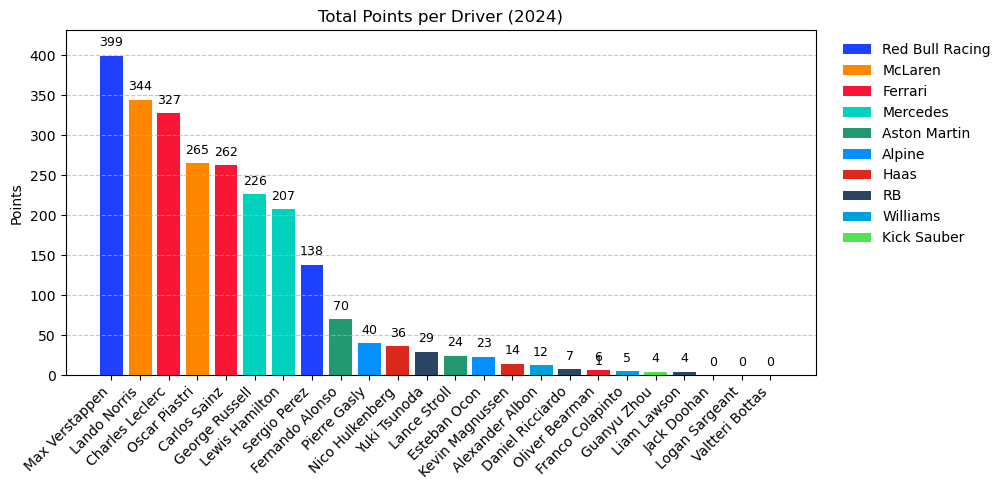

<BarContainer object of 25 artists>

In [17]:
df = race_results_clean.copy()
for pat, tgt in TEAM_REGEX_FIXES.items():
    df["Team"] = df["Team"].str.replace(pat, tgt, regex=True, case=False)

points_per_driver = (
    df.groupby(["Driver","Team"], as_index=False)["Points"].sum()
      .sort_values(["Points","Driver"], ascending=[False, True])
)

colors = points_per_driver["Team"].map(TEAM_COLORS).fillna("#999999")
legend_items = [Patch(facecolor=TEAM_COLORS[t], label=t)
                for t in points_per_driver["Team"].unique()
                if t in TEAM_COLORS]

plot_bar_with_labels(
    points_per_driver["Driver"],
    points_per_driver["Points"],
    colors=colors,
    title="Total Points per Driver (2024)",
    ylabel="Points",
    legend_items=legend_items
)

**Takeaway:** Verstappen leads with **399** points; Norris (**344**) and Leclerc (**327**) form a clear chase pack—consistent with what we see in wins/podiums later.

### Cumulative Championship Points per Driver
We track how each driver’s cumulative points evolve throughout the season. This lets us see who pulls away early, who improves mid-season, and how close rivalries developed.

In [18]:
# Base data
df = race_results_clean.copy()

In [19]:
# clean Team column just for this plot
df['Team'] = (
    df['Team'].astype(str).str.strip().str.replace(r'\s+', ' ', regex=True)
)
for pat, target in TEAM_REGEX_FIXES.items():
    df['Team'] = df['Team'].str.replace(pat, target, regex=True, case=False)

In [20]:
# Race order (use calendar if available; otherwise infer from results)
try:
    # If your calendar has a Column 'Track' in race order, use that:
    race_order = list(dfs["calendar"]["Track"])
except Exception:
    race_order = (
        df.groupby("Track")["No"].min()   # any stable per-race metric works
          .sort_values()
          .index.tolist()
    )

In [21]:
# Points per race per driver, then cumulative sum
race_points = (
    df.groupby(["Track", "Driver"])["Points"]
      .sum()
      .unstack(fill_value=0)
      .reindex(race_order)    # calendar order
      .fillna(0)
)
cum_points = race_points.cumsum()

In [22]:
# Map driver -> primary team; alternate linestyles per team
driver_team = (
    df.groupby("Driver")["Team"]
      .agg(lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[-1])
)
style_cycle = ['-', '--', ':', '-.']
team_style_index = {}
def next_style_for_team(team):
    i = team_style_index.get(team, 0)
    team_style_index[team] = (i + 1) % len(style_cycle)
    return style_cycle[i]

In [23]:
# For teammates: alternate linestyles within the same team
style_cycle = ['-', '--', ':', '-.']  # more than enough for any team
team_style_index = {}                 # team -> next style idx

def next_style_for_team(team):
    i = team_style_index.get(team, 0)
    team_style_index[team] = (i + 1) % len(style_cycle)
    return style_cycle[i]

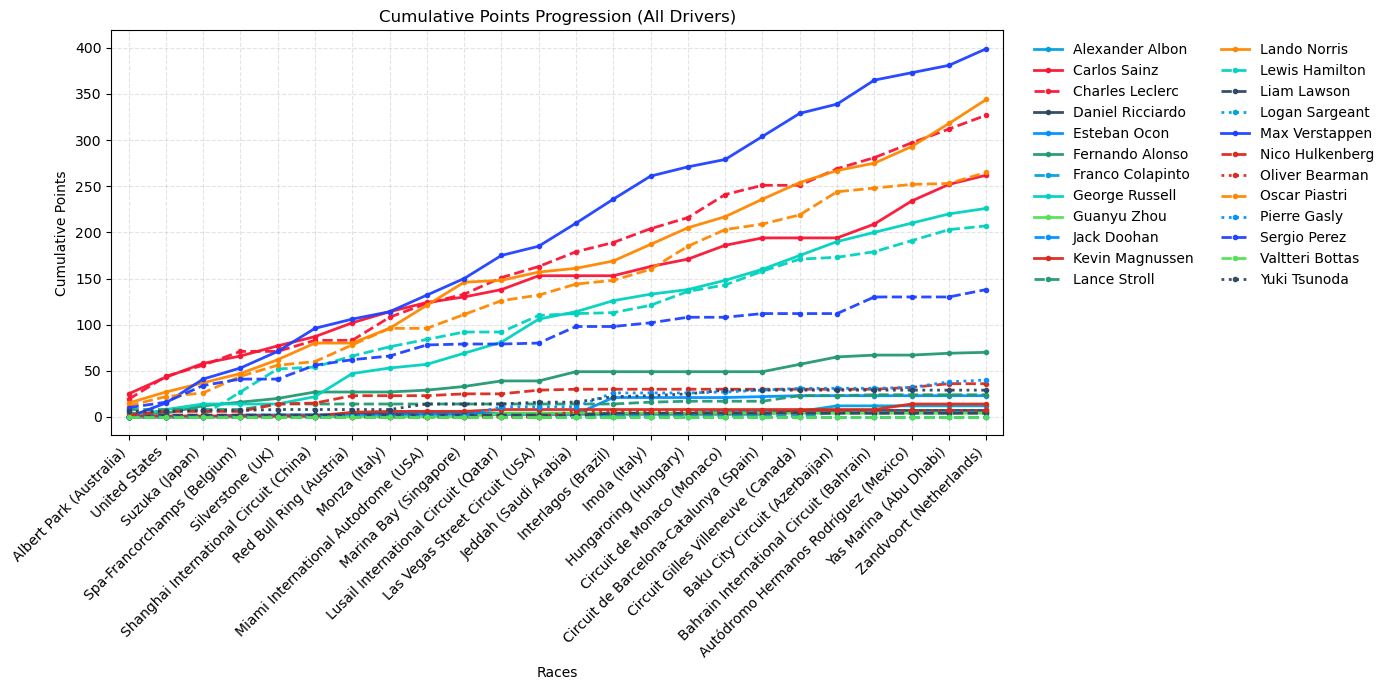

In [24]:
# Plot
plt.figure(figsize=(14, 7))
for drv in cum_points.columns:
    team = driver_team.get(drv, 'Unknown')
    color = TEAM_COLORS.get(team, '#999999')
    ls = next_style_for_team(team)
    plt.plot(
        cum_points.index,
        cum_points[drv],
        label=drv,
        color=color,
        linestyle=ls,
        linewidth=2,
        marker='o',
        markersize=3,
        alpha=0.95
    )

plt.title("Cumulative Points Progression (All Drivers)")
plt.xlabel("Races")
plt.ylabel("Cumulative Points")
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.35)
plt.margins(x=0.02, y=0.05)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', ncol=2, frameon=False)
plt.tight_layout()
plt.show()

**Takeaway:** Verstappen pulls away mid-season; Norris and Leclerc track each other closely; Mercedes duo rise later but never threaten P1.


### 🏆 Wins per Driver  
Here we count how many races each driver won during the 2024 season.

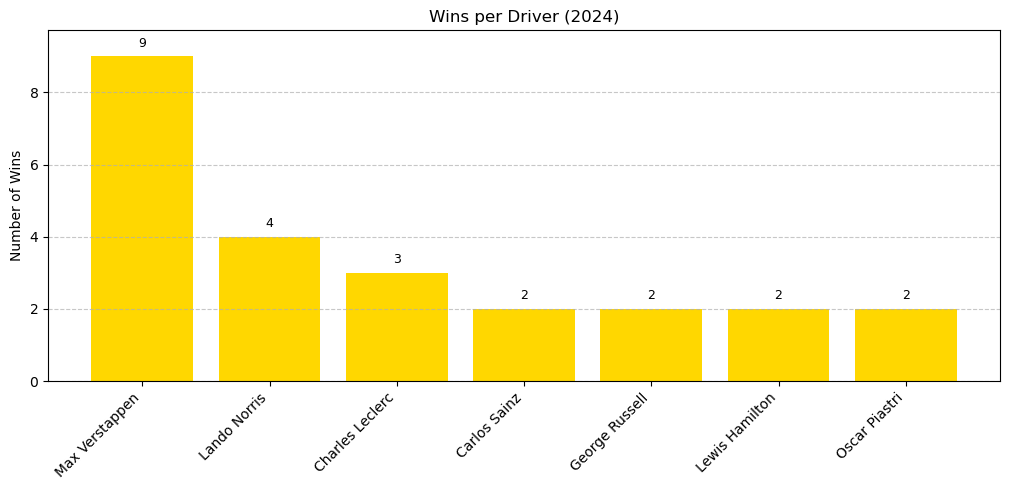

<BarContainer object of 7 artists>

In [25]:
# Count wins by driver (Position == 1 → race win)
wins_per_driver = (
    df.loc[df["Position"] == 1, "Driver"]
      .value_counts()
      .sort_values(ascending=False)
)

# Plot wins per driver as a bar chart
plot_bar_with_labels(
    x=wins_per_driver.index,
    y=wins_per_driver.values,
    colors="gold",
    title="Wins per Driver (2024)",
    ylabel="Number of Wins"
)

**Max Verstappen** secured **9 wins**, more than double any other driver. **Norris (4)** and **Leclerc (3)** were the closest challengers, while several drivers managed **2 wins**, reflecting a more competitive mid-field.

### Podiums per Driver
We count how many times each driver finished P1–P3 across the season and rank them from most to least. This is a simple consistency metric: lots of podiums usually means steady front-running pace even when a driver isn’t winning.

In [26]:
# Start from the cleaned race results
df = race_results_clean.copy()

In [27]:
# Count podium finishes (Position ≤ 3) per driver and sort high → low
podiums_per_driver = (
    df.loc[df["Position"].le(3), "Driver"]
      .value_counts()
      .sort_values(ascending=False)
)

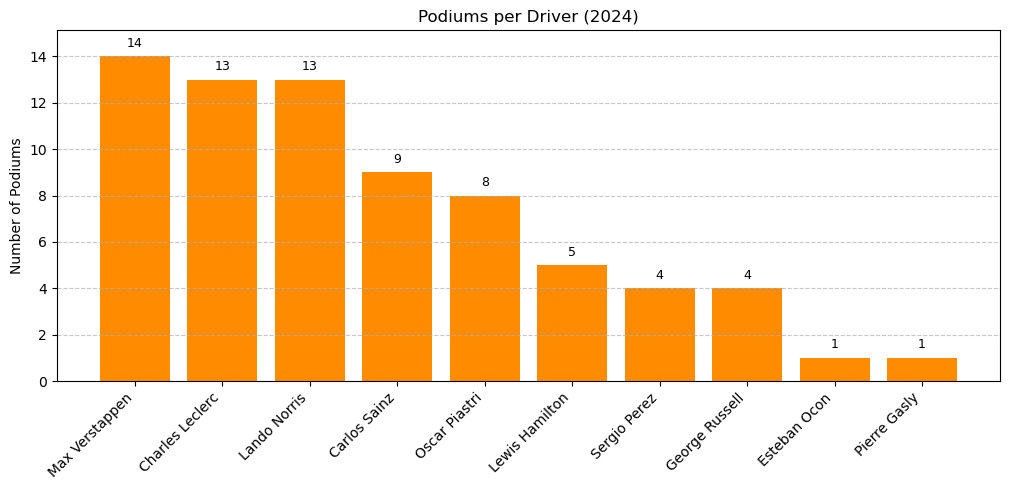

<BarContainer object of 10 artists>

In [28]:
# Plot (reuse the helper to keep style consistent)
plot_bar_with_labels(
    x=podiums_per_driver.index,            # driver names on x-axis
    y=podiums_per_driver.values,           # podium counts
    colors="#ff8c00",                      # single color (orange)
    title="Podiums per Driver (2024)",
    ylabel="Number of Podiums",
)

**Takeaway:** **Max Verstappen** leads with **14 podiums**, while **Norris** and **Lecler** are right behind on **13** each—evidence of strong, week-to-week consistency even when they didn’t win.

## 🏎️ Constructor (Team) Performance
We aggregate total driver points by team and visualize each team’s share of the season’s points. A donut chart makes it easy to compare proportions at a glance while still seeing the whole.

In [29]:
# Work on the cleaned results (keeps original frame untouched)
df = race_results_clean.copy()

In [30]:
# Aggregate points per team and keep a descending order
points_per_team = (
    df.groupby("Team", as_index=False)["Points"]
      .sum()
      .sort_values("Points", ascending=False)
)

In [33]:
# Donut chart: colors tied to TEAM_COLORS; keep our custom order (no auto-sorting)
fig = px.pie(
    points_per_team,
    names="Team",
    values="Points",
    hole=0.45,
    color="Team",
    color_discrete_map=TEAM_COLORS
)

# Show labels + % on slices, and keep the order from points_per_team
fig.update_traces(
    sort=False,
    textinfo="label+percent",
    hovertemplate="<b>%{label}</b><br>Points: %{value}<br>Share: %{percent}<extra></extra>"
)

# Title, legend title, and some margin for breathing room
fig.update_layout(
    title="Constructor Share of Total Points (Interactive)",
    legend_title_text="Team",
    margin=dict(t=60, r=40, b=40, l=40)
)

# Save HTML + show (PNG optional, see earlier note)
show_plotly(fig, name="constructor_share")

Saved constructor_share.png and constructor_share.html


In [68]:
from IPython.display import HTML, display
display(HTML('<a href="docs/constructor_share.html" target="_blank">Open interactive donut</a>'))

**Takeaway:** The top three teams — **McLaren (~25%)**, **Ferrari (~24%)**, and **Red Bull (~22%)** — account for **~71%** of all points, with **Mercedes (~18%)** clearly next. That concentration shows a four-team front pack with a sizable gap to the midfield.

## 🔁 Position Change Analysis
We compute **position change** per driver as grid − finish (positive = gained places), average it across races, and highlight who typically moves forward on Sundays versus those who slip back.

In [35]:
# Work from the cleaned results; keep the original frame untouched
df = race_results_clean.copy()

In [36]:
# Ensure numeric; coerce text like "DNF", "NC" -> NaN
df["Starting Grid"] = pd.to_numeric(df["Starting Grid"], errors="coerce")
df["Position"]      = pd.to_numeric(df["Position"],      errors="coerce")

Note: We excluded drivers with fewer than 3 race starts to avoid unstable averages from tiny samples.

In [37]:
# Remove rows without a valid finish (drop DNFs)
df = df.dropna(subset=['Starting Grid', 'Position'])

In [38]:
# Compute position change per entry (positive = gained positions in race)
df['position_change'] = df['Starting Grid'] - df['Position']

In [39]:
# avoid tiny-sample noise (e.g., reserve drivers with 1–2 starts)
races_per_driver = df.groupby("Driver").size()
df = df[df["Driver"].isin(races_per_driver[races_per_driver >= 3].index)]

In [40]:
# Average per driver (larger = typically gains more places)
avg_change = (df.groupby('Driver')['position_change']
                .mean()
                .sort_values(ascending=False))

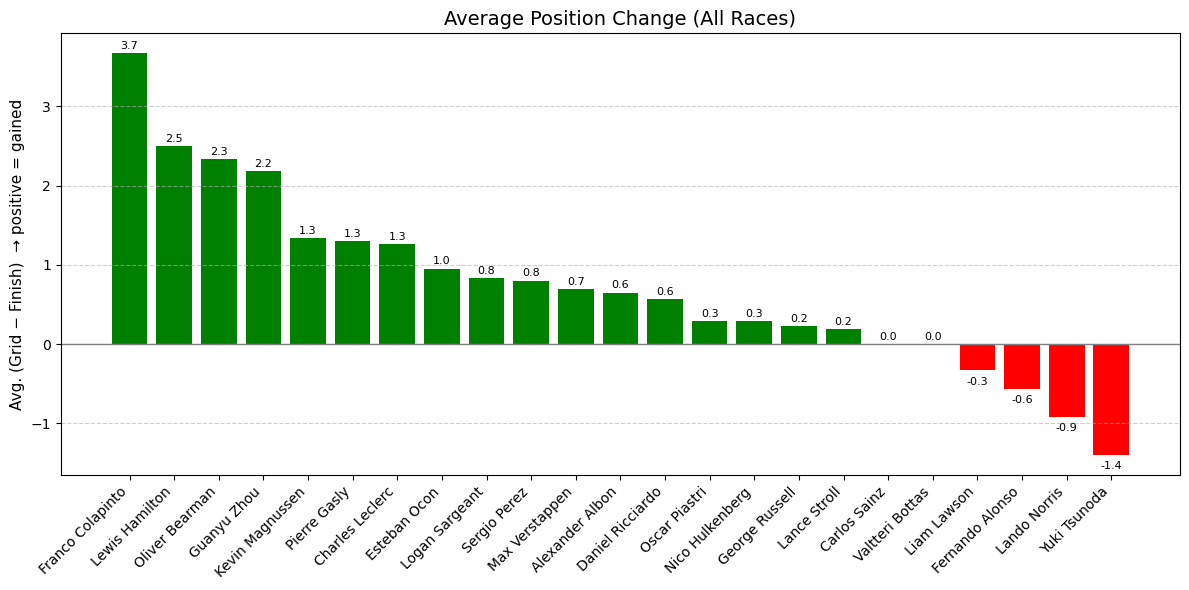

Biggest average gainers: Franco Colapinto (+3.7), Lewis Hamilton (+2.5), Oliver Bearman (+2.3). Biggest average losses: Fernando Alonso (-0.6), Lando Norris (-0.9), Yuki Tsunoda (-1.4).


In [41]:
# Colors: green for net gainers, red for net losers
colors = ['green' if v >= 0 else 'red' for v in avg_change.values]

plt.figure(figsize=(12,6))
bars = plt.bar(avg_change.index, avg_change.values, color=colors)
plt.title("Average Position Change (All Races)", fontsize=14)
plt.ylabel("Avg. (Grid − Finish)  → positive = gained", fontsize=11)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.axhline(0, color='gray', linewidth=1)

# Value labels with one decimal; place above/below depending on sign
for b in bars:
    h = b.get_height()
    y = h + (0.03 if h >= 0 else -0.08)
    va = 'bottom' if h >= 0 else 'top'
    plt.text(b.get_x()+b.get_width()/2, y, f"{h:.1f}", ha='center', va=va, fontsize=8)

plt.tight_layout()
plt.show()

# Auto-takeaway helpers
top3 = avg_change.head(3); bot3 = avg_change.tail(3)
print(
    f"Biggest average gainers: {', '.join([f'{n} ({v:+.1f})' for n,v in top3.items()])}. "
    f"Biggest average losses: {', '.join([f'{n} ({v:+.1f})' for n,v in bot3.items()])}."
)

**Takeaway:** The biggest average gainers typically move forward by **~2–4** positions per race, while a few drivers average small losses **(≈−0.5 to −1.5)**. This suggests meaningful **race-pace or strategy** strength for the top gainers and potential **qualifying/race-pace mismatch** for those averaging losses.

## ⏱️ Fastest Lap Analysis
We find the fastest lap driver for each race (using the minimum lap time), then count how many fastest laps each driver recorded in 2024. This highlights raw pace bursts and late-race tire strategy. Sprints aren’t included unless your dataset has sprint fastest laps as separate rows.

In [42]:
# Start from the cleaned results (keep the original frame untouched)
df = race_results_clean.copy()

In [43]:
# Keep only rows where a valid fastest-lap time exists
df_fl = df[df['Fastest Lap (s)'].notna()].copy()
df_fl["Fastest Lap (s)"] = pd.to_numeric(df_fl["Fastest Lap (s)"], errors="coerce")
df_fl = df_fl.dropna(subset=["Fastest Lap (s)"])

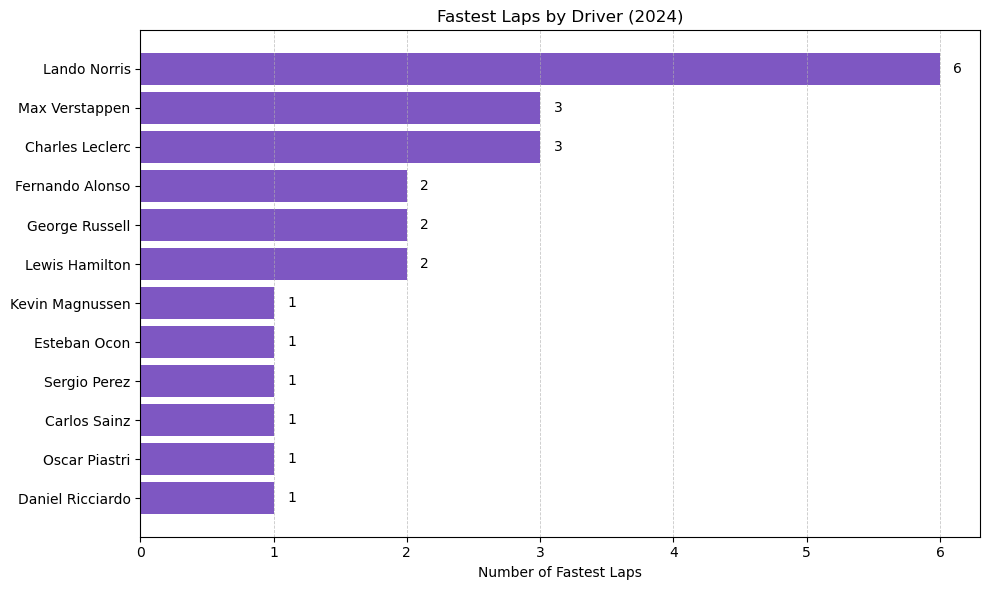

In [44]:
# Safety: if no fastest-lap data, bail out early
if df_fl.empty:
    print("No fastest-lap data available.")
else:
    # For each track, select the row with the minimum lap time (the fastest lap)
    idx = df_fl.groupby('Track')['Fastest Lap (s)'].idxmin()
    fastest_per_race = df_fl.loc[idx]

    # Count fastest laps by driver; sort ascending for a clean horizontal plot
    fastest_counts = (
        fastest_per_race['Driver']
        .value_counts()
        .sort_values(ascending=True)   # small→big reads nicer in barh
    )
# Plot
    plt.figure(figsize=(10, 6))
    bars = plt.barh(fastest_counts.index, fastest_counts.values, color='#7E57C2')
    plt.title('Fastest Laps by Driver (2024)')
    plt.xlabel('Number of Fastest Laps')
    plt.grid(axis='x', linestyle='--', linewidth=0.6, alpha=0.7)

    # Value labels at the right end of each bar
    for b in bars:
        w = b.get_width()
        plt.text(w + 0.1, b.get_y() + b.get_height()/2, f'{int(w)}', va='center')

    plt.tight_layout()
    plt.show()

In [45]:
# Show the underlying table
fastest_table = (
    fastest_per_race.loc[:, ["Track","Driver","Fastest Lap (s)","Team"]]
    .sort_values("Track")
    .reset_index(drop=True)
)
display(fastest_table.head(10))

,Track,Driver,Fastest Lap (s),Team
0,Albert Park (Australia),Charles Leclerc,79.813,Ferrari
1,Autódromo Hermanos Rodríguez (Mexico),Charles Leclerc,78.336,Ferrari
2,Bahrain International Circuit (Bahrain),Max Verstappen,92.608,Red Bull Racing
3,Baku City Circuit (Azerbaijan),Lando Norris,105.255,McLaren
4,Circuit Gilles Villeneuve (Canada),Lewis Hamilton,74.856,Mercedes
5,Circuit de Barcelona-Catalunya (Spain),Lando Norris,77.115,McLaren
6,Circuit de Monaco (Monaco),Lewis Hamilton,74.165,Mercedes
7,Hungaroring (Hungary),George Russell,80.305,Mercedes
8,Imola (Italy),George Russell,78.589,Mercedes
9,Interlagos (Brazil),Max Verstappen,80.472,Red Bull Racing


Takeaway: **Lando Norris** leads with **6** fastest laps, ahead of **Verstappen and Leclerc (3 each)**. That suggests Norris frequently had strong late-race pace or clean air for push laps—even when not winning the race. Fastest laps can reflect tire strategy and track position as much as outright race dominance.

# DNF Analysis (Did Not Finish)
We flag DNFs as rows where the race Position is missing (driver did not receive a classified finishing position), then count DNFs by **driver**, **team**, and **track**. This highlights reliability issues and incident-prone venues.

In [46]:
# DNF mask (simple & robust)
dnf_mask = race_results_clean["Position"].isna()

## DNFs per Driver

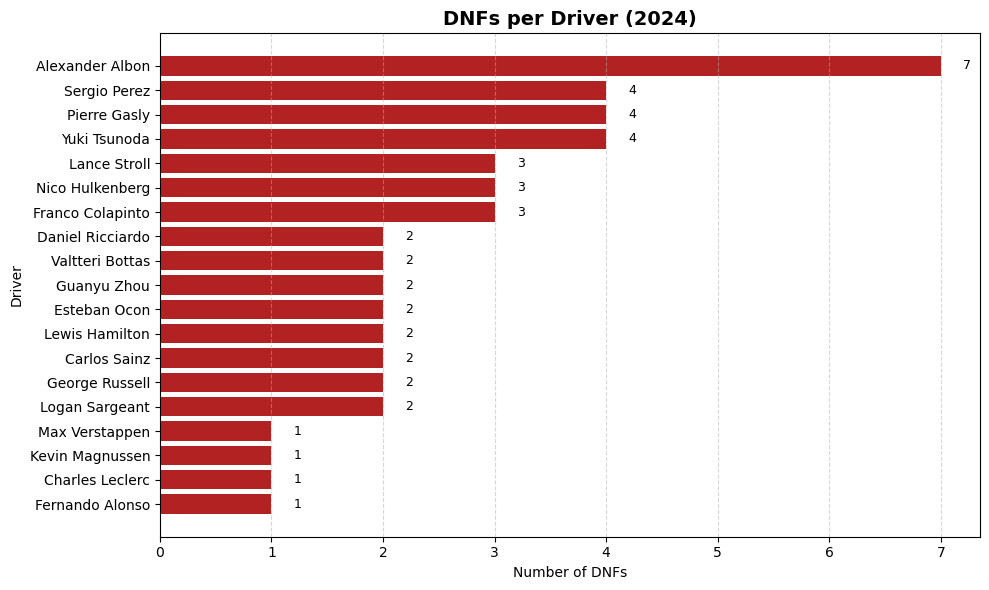

In [47]:
dnfs_driver = (race_results_clean.loc[dnf_mask, "Driver"]
               .fillna("Unknown")
               .value_counts())

plt.figure(figsize=(10,6))
bars = plt.barh(dnfs_driver.index, dnfs_driver.values, color='firebrick')
plt.title('DNFs per Driver (2024)', fontsize=14, weight='bold')
plt.xlabel('Number of DNFs'); plt.ylabel('Driver')
plt.grid(axis='x', linestyle='--', alpha=0.5)
for b in bars:
    w = b.get_width()
    plt.text(w + 0.2, b.get_y()+b.get_height()/2, f'{int(w)}', va='center', fontsize=9)
plt.gca().invert_yaxis()
plt.tight_layout(); plt.show()

## DNFs per Team

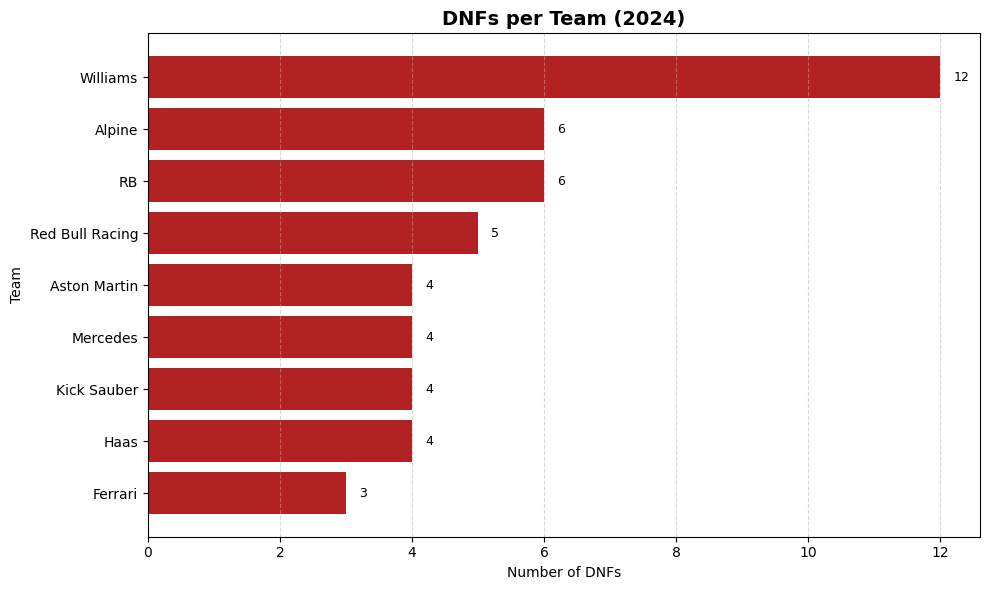

In [48]:
dnfs_team = (race_results_clean.loc[dnf_mask, "Team"]
             .fillna("Unknown")
             .value_counts())

plt.figure(figsize=(10,6))
bars = plt.barh(dnfs_team.index, dnfs_team.values, color='firebrick')
plt.title('DNFs per Team (2024)', fontsize=14, weight='bold')
plt.xlabel('Number of DNFs'); plt.ylabel('Team')
plt.grid(axis='x', linestyle='--', alpha=0.5)
for b in bars:
    w = b.get_width()
    plt.text(w + 0.2, b.get_y()+b.get_height()/2, f'{int(w)}', va='center', fontsize=9)
plt.gca().invert_yaxis()
plt.tight_layout(); plt.show()

# DNFs By track

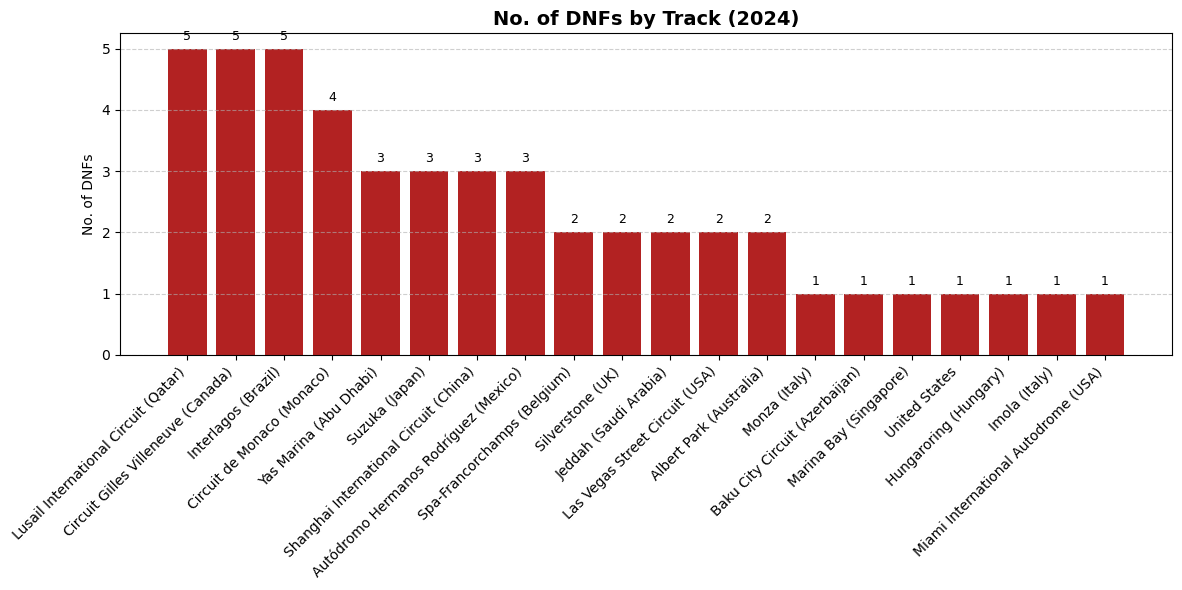

In [49]:
dnf_by_track = (race_results_clean.loc[dnf_mask, "Track"]
                .fillna("Unknown")
                .value_counts()
                .sort_values(ascending=False))

plt.figure(figsize=(12,6))
bars = plt.bar(dnf_by_track.index, dnf_by_track.values, color='firebrick')
plt.title('No. of DNFs by Track (2024)', fontsize=14, weight='bold')
plt.ylabel('No. of DNFs')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
for b in bars:
    h = b.get_height()
    plt.text(b.get_x()+b.get_width()/2, h + 0.1, f'{int(h)}',
             ha='center', va='bottom', fontsize=9)
plt.tight_layout(); plt.show()

Takeaway: DNFs were concentrated among a few drivers and teams. **Alexander Albon** led with **7 DNFs**, while **Perez**, **Gasly**, and **Tsunoda** had **4** each. By teams, **Williams** topped the list with **12 DNFs**, ahead of **Alpine/RB (6)**. The most incident-prone venues were **Lusail (Qatar)**, **Montreal (Canada)**, **Interlagos (Brazil**), **and Monaco (≈ 5 DNFs each)**. While some DNFs reflect **mechanical** or **reliability issues**, others were due to **driver accidents in tough conditions**—for example, **Brazil’s wet race** saw multiple drivers crash out.

## 🏎️ Sprint vs Main Race Performance  

We compare each driver’s average finishing position in sprints vs full (main) races to see who excels in short-run bursts and who scales better over GP distance.  

### What this cell does
- **Load & tag** sprint and main results.  
- **Coerce finishing positions** to numbers (`DNF/NC → NaN`) so averages are meaningful.  
- **Compute per-driver averages** by session, keeping only drivers who did both.  
- **Visualize with two plots**:  
  - **Scatter plot** → each point is a driver; the 45° line means “equally good in both”.  
  - **Δ bar** → Sprint − Main (negative = better in sprints, positive = better in mains).  

In [50]:
# Collect only what we need
race_df   = dfs["race_results"][["Track","Driver","Position"]].copy()
sprint_df = dfs["sprint_results"][["Track","Driver","Position"]].copy()

In [51]:
# Tag session and clean columns the same way for both
race_df["Session"]   = "Main"
sprint_df["Session"] = "Sprint"

for d in (race_df, sprint_df):
    # keep only numeric positions; DNF/NC → NaN
    d["Position"] = d["Position"].astype(str).str.extract(r"(\d+)")[0].astype(float)
    d["Driver"]   = d["Driver"].astype(str).str.strip().str.title()

In [52]:
# Stack together and compute averages
combined = pd.concat([race_df, sprint_df], ignore_index=True)

avg_finish = (
    combined.dropna(subset=["Position"])
            .groupby(["Driver","Session"])["Position"]
            .mean()
            .unstack()              # columns: ["Main", "Sprint"] if both exist
            .dropna()               # keep only drivers with both
            .rename(columns={"Main": "Main Race"})
)

## Scatter plot
 - Points **on the line** → equal performance in sprints and mains.  
 - Points **below/right** → better in mains (stronger over race distance).  
 - Points **above/left** → better in sprints (stronger in short runs).  

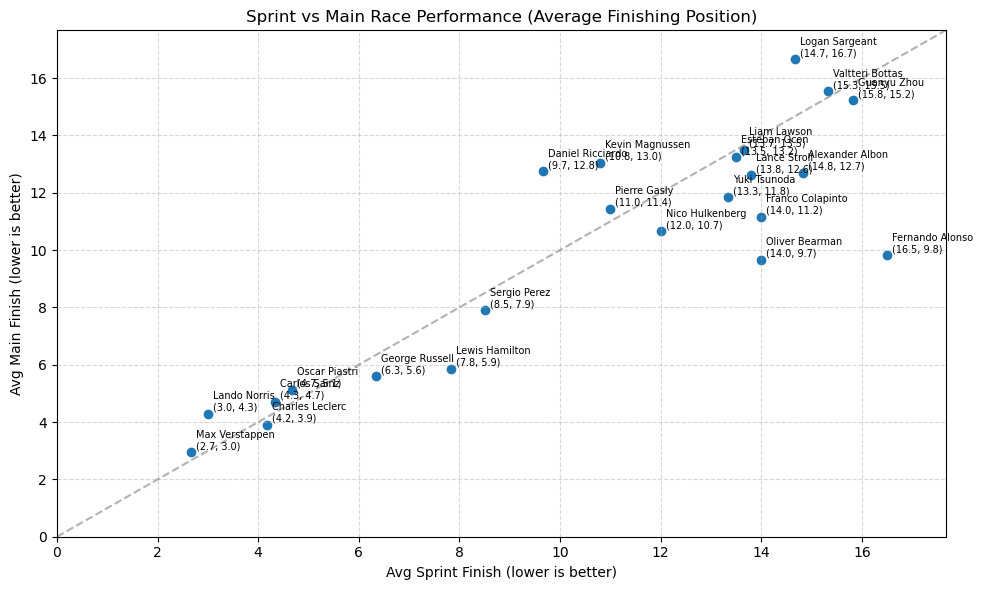

In [53]:
# plot
avg = avg_finish.sort_values("Main Race")

plt.figure(figsize=(10,6))
plt.scatter(avg["Sprint"], avg["Main Race"])
lims = [0, float(avg.to_numpy().max()) + 1]
plt.plot(lims, lims, "--", color="gray", alpha=0.6)   # 45° reference
plt.xlabel("Avg Sprint Finish (lower is better)")
plt.ylabel("Avg Main Finish (lower is better)")
plt.title("Sprint vs Main Race Performance (Average Finishing Position)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.xlim(lims); plt.ylim(lims)

# small labels
for drv, (s, m) in avg[["Sprint","Main Race"]].iterrows():
    plt.text(s + 0.1, m + 0.1, f"{drv}\n({s:.1f}, {m:.1f})", fontsize=7)

plt.tight_layout()
plt.show()

## Delta bar
 - **Green (negative)** → relatively stronger in sprints.  
 - **Red (positive)** → relatively stronger in mains.  

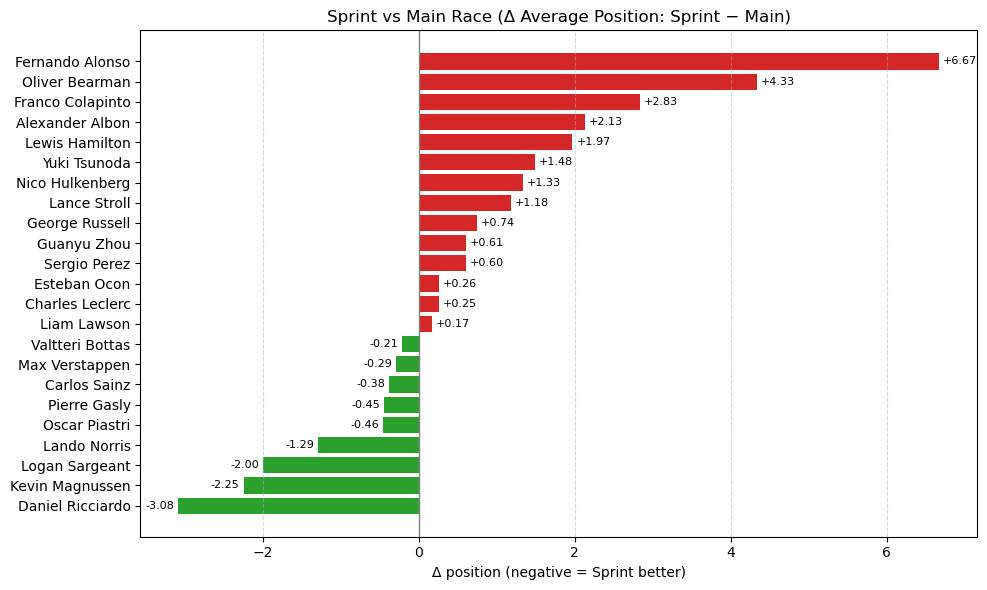

In [54]:
# plot
delta = (avg_finish["Sprint"] - avg_finish["Main Race"]).sort_values()

plt.figure(figsize=(10,6))
bars = plt.barh(
    delta.index, delta.values,
    color=["#2ca02c" if v < 0 else "#d62728" for v in delta.values]  # green=better in sprint
)
plt.axvline(0, color="gray", linewidth=1)
for b in bars:
    w = b.get_width()
    plt.text(
        w + (0.05 if w >= 0 else -0.05),
        b.get_y() + b.get_height()/2,
        f"{w:+.2f}",
        va="center",
        ha="left" if w >= 0 else "right", fontsize=8
    )

# labels
plt.title("Sprint vs Main Race (Δ Average Position: Sprint − Main)")
plt.xlabel("Δ position (negative = Sprint better)")
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

**Takeaway:** This comparison reveals who adapts across formats, and whether raw pace (sprints) translates into consistency over GP distance (mains).  

## 🏁 Qualifying vs Race Result  

We check how **grid position** relates to **race finish**, and identify drivers who consistently gain or lose places.  

**What this cell does**  
- Merge qualifying and race results into one dataset.  
- Use `Starting Grid` when available (fallback to qualifying).  
- Compute **correlation** (Pearson & Spearman).  
- Plot **scatter** (grid vs finish) with a 45° guide.  
- Summarize average grid vs finish delta per driver.  

In [55]:
# Build merged dataset (grid vs finish) 
qual = dfs["qualifying"].copy()
race = dfs["race_results"].copy()

for df0 in (qual, race):
    df0["Driver"] = df0["Driver"].astype(str).str.strip().str.title()
    df0["Track"]  = df0["Track"].astype(str).str.strip()

qual["Q_Pos"] = pd.to_numeric(qual["Position"], errors="coerce")
race["R_Pos"] = pd.to_numeric(race["Position"], errors="coerce")

m = pd.merge(
    race[["Track","Driver","R_Pos","Starting Grid"]],
    qual[["Track","Driver","Q_Pos"]],
    on=["Track","Driver"],
    how="left"
)

In [56]:
# Prefer race Starting Grid; fallback to qualifying
m["Grid"] = m["Starting Grid"].where(m["Starting Grid"].notna(), m["Q_Pos"])
m = m.dropna(subset=["Grid","R_Pos"]).copy()
m["Grid"] = m["Grid"].astype(float)
m["R_Pos"] = m["R_Pos"].astype(float)

In [57]:
# Map driver → primary team
driver_team = (
    race_results_clean.groupby("Driver")["Team"]
      .agg(lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[-1])
)
m["Team"] = m["Driver"].map(driver_team).fillna("Unknown")

In [58]:
# Correlations and deltas
r   = m["Grid"].corr(m["R_Pos"], method="pearson")
rho = m["Grid"].corr(m["R_Pos"], method="spearman")
tmp = m.assign(delta=m["Grid"] - m["R_Pos"])  # + = gained positions

**How to read it**  
- Points on the dashed line → finished where they started.  
- Below/right → gained places.  
- Above/left → lost places.  

In [59]:
# Scatter plot with Plotly
fig = px.scatter(
    m,
    x="Grid", y="R_Pos",
    color="Team",
    hover_data=["Driver","Track","Grid","R_Pos"],
    color_discrete_map=TEAM_COLORS
)

fig.update_layout(
    title=f"Qualifying vs Race Result • Pearson r = {r:.2f} (Spearman ρ = {rho:.2f})",
    xaxis_title="Grid Position (lower = better)",
    yaxis_title="Race Finish (lower = better)",
    legend_title_text="Team",
    width=900, height=650
)

# 45° guide line
lims = [0.5, float(max(m["Grid"].max(), m["R_Pos"].max()) + 0.5)]
fig.add_shape(
    type="line", x0=lims[0], y0=lims[0], x1=lims[1], y1=lims[1],
    line=dict(dash="dash", width=1, color="gray")
)
# Save HTML + show (PNG optional, see earlier note)
show_plotly(fig, name="Qualifying vs Race Result")

Saved Qualifying vs Race Result.png and Qualifying vs Race Result.html


In [67]:
from IPython.display import FileLink, HTML, display
display(HTML('<a href="docs/Qualifying_vs_Race_Result.html" target="_blank">Open interactive scatter plot</a>'))

In [61]:
summary = (
    tmp.groupby("Driver")
       .agg(
           Races=("delta", "size"),
           Avg_Grid=("Grid", "mean"),
           Avg_Finish=("R_Pos", "mean"),
           Avg_Delta=("delta", "mean")
       )
       .sort_values("Avg_Delta", ascending=False)
       .round(2)
)

display(summary)

# quick callouts
best  = summary.iloc[0]
worst = summary.iloc[-1]
print(f"Top average gainer: {best.name} (+{best.Avg_Delta:.2f} places over {best.Races} races).")
print(f"Largest average loss: {worst.name} ({worst.Avg_Delta:.2f} over {worst.Races} races).")

,Races,Avg_Grid,Avg_Finish,Avg_Delta
Driver,,,,
Franco Colapinto,6,14.83,11.17,3.67
Lewis Hamilton,22,8.36,5.86,2.50
Oliver Bearman,3,12.00,9.67,2.33
Guanyu Zhou,22,17.41,15.23,2.18
Jack Doohan,1,17.00,15.00,2.00
Kevin Magnussen,21,14.38,13.05,1.33
Pierre Gasly,20,12.75,11.45,1.30
Charles Leclerc,23,5.17,3.91,1.26
Esteban Ocon,21,14.19,13.24,0.95


Top average gainer: Franco Colapinto (+3.67 places over 6.0 races).
Largest average loss: Yuki Tsunoda (-1.40 over 20.0 races).


**Takeaway**  
- Grid vs finish is **strongly correlated** (≈0.78).  
- Some drivers consistently **move forward** (race pace > quali pace), while others tend to **slip back** on Sundays.  

## ✅ Conclusion

This analysis turned raw 2024 F1 data into clear stories about **drivers, teams, and race dynamics**.

**What stood out**
- **Championship picture:** Verstappen topped points; Norris and Leclerc formed the main chase.  
- **Constructors:** A **four-team front pack** (McLaren, Ferrari, Red Bull, Mercedes) captured ~**70%+** of all points—clear separation from the midfield.  
- **Race craft vs single-lap pace:** **Qualifying strongly correlates with finishing** (Pearson ≈ **0.78**), but several drivers consistently **gain** (race pace/strategy) or **lose** places on Sundays.  
- **Fastest laps:** Norris led, hinting at late-race pace or clean-air push laps not always tied to race wins.  
- **Reliability & incidents:** DNFs were concentrated—**Albon** led among drivers; **Williams** among teams. Tracks like **Lusail, Montreal, Interlagos, and Monaco** were the most incident-prone in this dataset.

**Limitations**
- No explicit modelling of **pit strategy, safety cars, tyre compounds, or weather** (e.g., Brazil rain).  
- Sprint results and reserve drivers can create **small-sample noise**; we filtered some but not all edge cases.  
- Data reflects the provided CSVs; subtle timing/penalty nuances may not be captured.

**If I had another day**
- Add **per-track profiles** (overtake difficulty, safety-car rates) and **teammate head-to-head**.  
- Build a light **predictive model** (e.g., predict finish from grid, team form, track effects).  
- Layer in **tyre stint** or **pit-loss** estimates to separate strategy from raw pace.  

**Final note**
- My first project shows solid, **Python + data-analysis** skills: clean inputs, modular helpers, readable charts, and concise insights. Im very proud of what I have done so far.

# All right, everyone. That concludes our F1 2024 data analysis!
# Thank you very much for reading & take care!